# Google Colab 한글 폰트 설치

In [1]:
import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

In [2]:
# 필요한 패키지
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import linalg as la
import scipy.stats as ss
import scipy.special

# 한글출력
plt.rcParams['font.family'] = 'Malgun Gothic' #  Windows 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# 필요한 패키지 2
from pgmpy.factors.discrete import JointProbabilityDistribution as JPD
import sympy

scipy.__version__

'1.15.3'

- 테스트

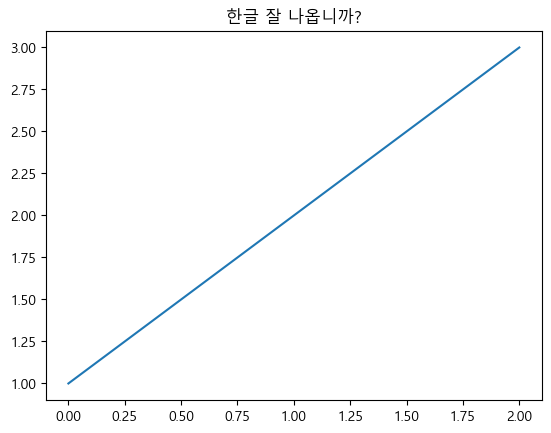

In [3]:
plt.plot([1, 2, 3])
plt.title("한글 잘 나옵니까?")
plt.show()

In [4]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

# 라이브러리 불러오기

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 시계열 시각화 맛보기

## matplotlib 설정

In [6]:
plt.rcParams['axes.unicode_minus'] = False

# 정상적 ARMA 프로세스
- ARMA(1, 1) 프로세스 시뮬레이션

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
# from tqdm.auto import tqdm
from tqdm.auto import tqdm  # 일반 CLI용 progress bar
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

- 귀무가설 기각 : 정상성

In [8]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.4298786820426965
p-value: 1.707846668009642e-08


## 자기상관관계
- 사인 곡선 패턴
- 계수의 마지막은 유의한 시점이 지연2로 보일 수도 있음
- 시뮬레이션 데이터는 MA(1) 프로세스 기반, 즉 지연1까지만 유효
- 결론 : 차수 q에 대한 유용한 정보 제공 못함

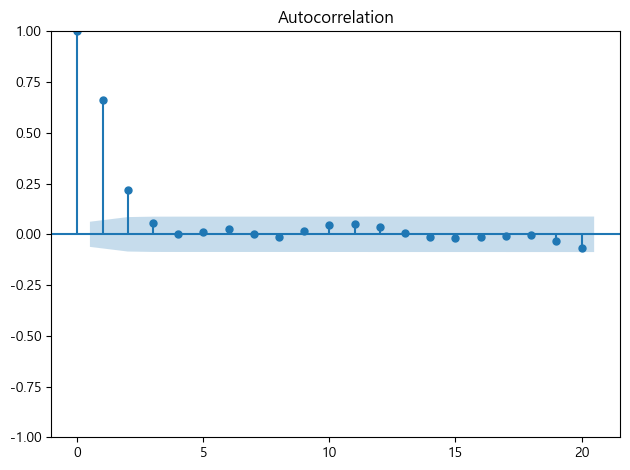

In [9]:
plot_acf(ARMA_1_1, lags=20);
plt.tight_layout()

## 편자기상관관계
- 사인 곡선 패턴
- 차수 p의 값을 유추할 수 없음
- ARMA(1, 1) 프로세스 시뮬레이션한 데이터이지만 지연 1을 지난 후에도 계수가 유의함.
- PACF로도 차수 확인 불가

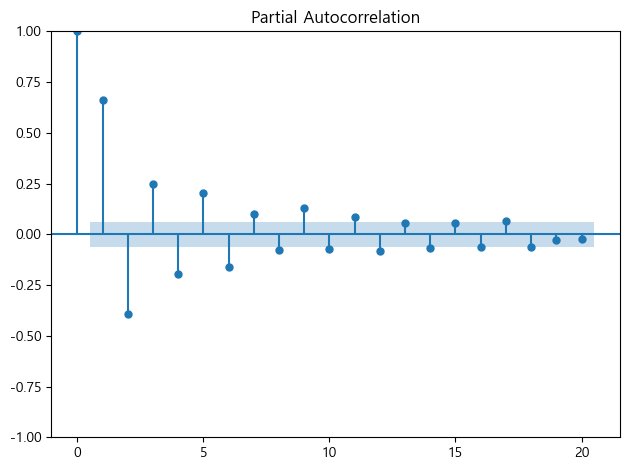

In [10]:
plot_pacf(ARMA_1_1, lags=20);
plt.tight_layout()

# AIC 활용한 모델 선택

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


## ARMA 모델 적합 위한 함수

In [12]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [14]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

## aic 기준으로 선택

100%|██████████████████████████████████████████| 16/16 [00:01<00:00,  9.76it/s]


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.001496
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


# 잔차 분석


## 정성적 분석 : Q-Q 도식 확인

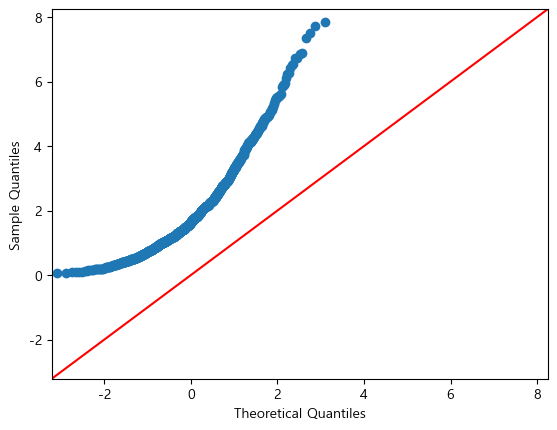

In [15]:
from statsmodels.graphics.gofplots import qqplot

gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)

qqplot(gamma, line='45');

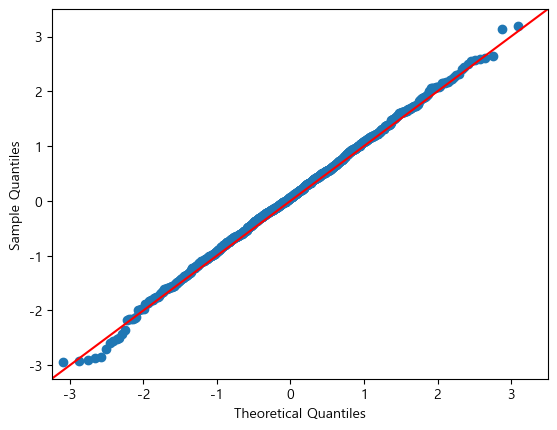

In [16]:
normal = np.random.normal(size=1000)

qqplot(normal, line='45');

## 정량적 분석 : 융-박스 테스트
** 잔차 : 모델의 실제값과 예측값의 차이
- 귀무가설 : 잔차는 독립적으로 분포되어 있음
- 대립가설 : 잔차가 독립적으로 분포되어 있지 않고, 상관관계가 있음
- 귀무가설을 채택해야만 예측이 가능하다. 즉, p_valuedms 0.05 이상 나와야 한다.

## 잔차 분석 수행

In [17]:
model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

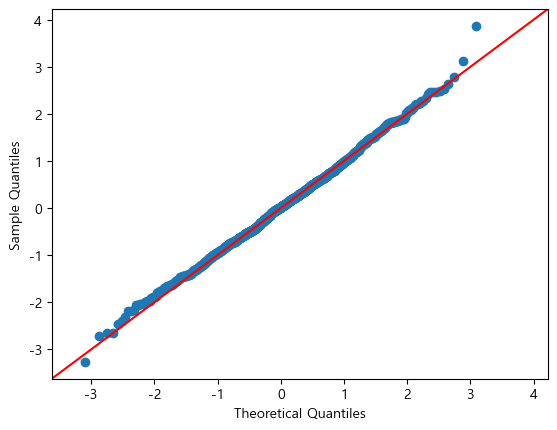

In [18]:
from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

## 그래프 해석
- 왼쪽 상단 도식 : 전체 데이터 집합의 잔차
  + 특이한 추세 미 존재, 평균 시간이 지나도 안정적으로 백색소음과 같은 정상성
- 오른쪽 상단 도식 : 잔차의 히스토그램
  + 잔차가 백색소음에 가까움
- 오른쪽 하단 도식 : 잔차의 자기상관함수

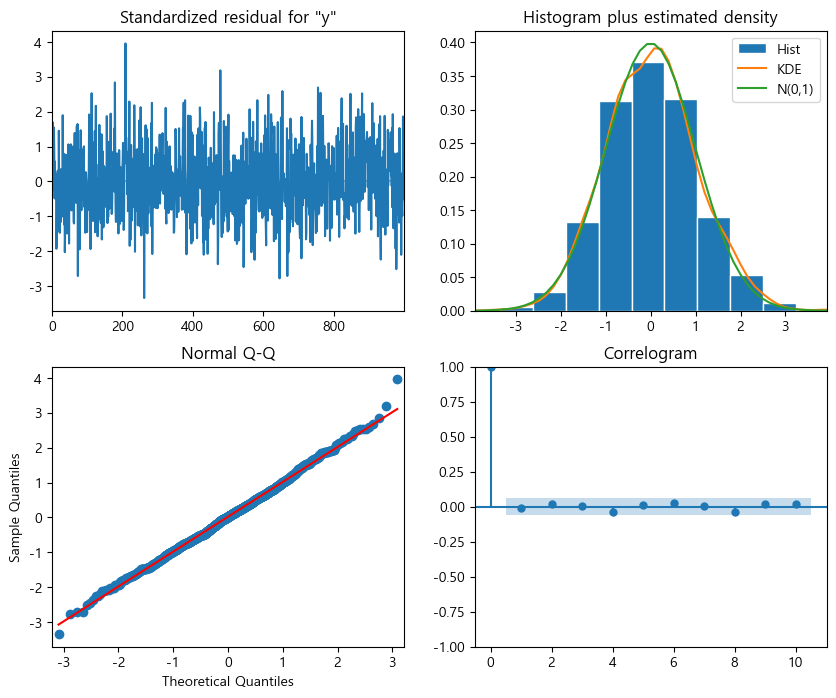

In [19]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


# 대역폭 데이터 활용, 일반적 모델링 절차

## 데이터 불러오기

In [21]:
DATA_PATH = './data/'

df = pd.read_csv(DATA_PATH + 'bandwidth.csv')
df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


## 시각화

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## ADF 테스트
- 귀무가설 : 시계열이 비정상적이다.
- 대립가설 : 시계열이 정상적이다.

In [ ]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

- 1차 차분

In [ ]:
import matplotlib.pyplot as plt

bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

## ACF와 PACF 그래프

In [ ]:
plot_acf(bandwidth_diff, lags=20);
plt.tight_layout()

In [ ]:
plot_pacf(bandwidth_diff, lags=20);
plt.tight_layout()

## 훈련집합 및 테스트 집합 시각화

In [ ]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## ARMA 모델 피팅

In [ ]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

## 잔차 분석

In [ ]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

In [ ]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [ ]:
residuals = model_fit.resid

In [ ]:
acorr_ljungbox(residuals, np.arange(1, 11, 1))

## 대역폭 사용량 예측하기

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

In [ ]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# ARIMA : 비정상 시계열

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.auto import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 데이터 수집

In [ ]:
df = pd.read_csv(DATA_PATH + 'jj.csv')
df.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 단위근 검정
- 차분 2회 지정

In [ ]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## 예측 구간 설정

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

## ARIMA 최적화

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

- 조합 목록

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

- 조합 목록 결과

In [ ]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

## ARIMA 모델 적용

In [ ]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

## 모델 결과 확인
- 왼쪽 상단 : 시간에 따른 잔차
  + 분산이 일정하지 않음, 백색 소음과 차이 존재
- 오른쪽 상단 : 잔차의 분포, 정규분포에 가까움
- Q-Q 도식 : 직선적인 선 표시
- 상관관계도 : 지연 3에서 계수가 유의함
- 모델의 오차가 무작위적

In [ ]:
model_fit.plot_diagnostics(figsize=(10,8));

- 정량적 관점 테스트
  + 모두 p값이 0.05보다 큼, 귀무가설 기각하지 않고, 백색소음과 마찬가지로 상관관계 없음

In [ ]:
residuals = model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

## 테스트

In [ ]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

In [ ]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

- 파선으로 표시된 ARIMA(3, 2, 3) 모델의 예측이 1980년에 관측된 데이터와 거의 완벽하게 겹치는 것 확인

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

## 기존 모델과 결과 비교

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

In [ ]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

# SARIMA (계절성 고려)
- 계절적 자기회귀누적이동평균 모델

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.auto import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 데이터 가져오기

In [ ]:
df = pd.read_csv(DATA_PATH + 'air-passengers.csv')
df.head()

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 계절성 데이터 확인

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'], markevery=np.arange(6, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 계절별 패턴 패턴

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

## 시계열 분해

In [ ]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

- 계절성 시계열이 없는 그래프

In [ ]:
linear_ts = np.arange(0, 144, 1)

decomposition = STL(linear_ts, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-1, 1)

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax4.set_ylim(-1, 1)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## ADF 테스트

In [ ]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

- 두번 차분 진행

In [ ]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'][13:], df_diff_seasonal_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers - diff')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 예측 구간 설정

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers)')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## ARIMA 모델 적합
- d = 2
- p와 q 차수 구하기
  + 0에서 12사이의 값 적용 (데이터 매월 측정, 계절적 요인 있음 확인)
- 최상의 SARIMA 모델 선택하는 함수 정의
  + 기존 ARIMA 모델 업데이트

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

- 가능한 모든 조합 설정
  + 0에서 12사이의 값 적용

In [ ]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0] # 계절적 요인 없다고 가정하고 0으로 상수
Qs = [0] # 계절적 요인 없다고 가정하고 0으로 상수

d = 2 # 차분 2회
D = 0 # 계절적 요인 없다고 가정하고 0으로 상수
s = 12 # 빈도 슬라이드에서는 m이라고 표현

ARIMA_order_list = list(product(ps, qs, Ps, Qs))
ARIMA_order_list

In [ ]:
train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

- AIC가 가장 낮은 모델은 $SARIMA(11, 2, 3)(0, 0, 0)_{12}$ 모델
  + ARIMA(11, 2, 3) 모델과 동일

### 잔차 분석
- ARIMA 모델 적합 후, 잔차의 진단 도식화

In [ ]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

- 융-박스 테스트
  + 처음 두 값을 제외하고 모두 0.05보다 큼
  + 지연3부터 상관관계가 없다는 결론 내림

In [ ]:
residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

### 예측 테스트
- 단순한 계절 예측
- ARIMA 모델 예측

In [ ]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

## SARIMA 모델 적합

### ADF 확인

In [ ]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

In [ ]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

### SARIMA 모델 적합
- 한 번의 차분, d = 1과 한번의 계절적 차분 D = 1 수행

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

- AIC가 가장 낮은 모델은 $SARIMA(2, 1, 1)(1, 1, 2)_{12}$ 모델

In [ ]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

## 잔차 분석

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

## 예측 테스트

In [ ]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 기본 모델과 결과 비교

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

In [ ]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.show()

# SARIMAX : 외생변수 추가

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.auto import tqdm
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## GDP 데이터
- realgdp : 실질 GDP (목표 변수 또는 내생 변수)
- realcons : 실질 개인 소비 지출
- realinv : 실질 국내 총 민간 투자
- realgovt : 실질 연방 소비 지출 및 투자
- realdpi : 실질 민간 가처분 소득
- cpi : 분기 말 소비자물가지수
- m1 : M1 명목 통화량
- tbilrate : 3개월 만기 국채의 분기별 월평균 금리
- unemp : 실업률
- pop : 분기 말 총 인구
- infl : 인플레이션율
- realint : 실질 이자율

In [ ]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

In [ ]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

plt.show()